<a href="https://colab.research.google.com/github/joelwwiggins/car_ml/blob/main/Copy_of_notebook_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [84]:
#import csv from path
#drop first row and column
df1 = pd.read_csv('CSVLog_20221218_084434.csv', skiprows=1)


In [85]:
#drop first column
df1_col=df1.iloc[:,1:]
df=df1_col

In [86]:
#convert to numpy array
df_np=df.to_numpy()








In [87]:
#train test split the data into the autoencoder input
#create a a model with an autoencoder to have the output be the input
#compile the model 
#fit the model with the training data and 100 epochs
#evaluate the model with the test data
#predict the model with the test data
#plot the predicted values against the actual values
#plot the loss and accuracy of the model
#save the model
#import the necessary libraries

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import UpSampling1D as upsampling1D

#use df_np from previous cell
#set scaler
scaler = StandardScaler()
#train test split the data for the autoencoder input
X_train, X_test = train_test_split(df_np, test_size=0.2, random_state=42)
#scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#reshape the data for the autoencoder input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#set the model
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(16, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(8, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(16, 2, activation='relu'))
model.add(upsampling1D(2))
model.add(Conv1D(32, 2, activation='relu'))
model.add(upsampling1D(2))
model.add(Conv1D(64, 2, activation='relu'))
model.add(upsampling1D(2))

model.add(Conv1D(1, 2, activation='relu'))
model.add(upsampling1D(2))


#compile the model
model.compile(optimizer='adam', loss='mse')




#set early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

#fit the model
model.fit(x=X_train,y=X_train,epochs=2, validation_data=(X_test,X_test), callbacks=[early_stop])

#evaluate the model
model.evaluate(X_test,X_test,verbose=0)

#predict the model
test_predictions = model.predict(X_test)



#save the model
model.save('autoencoder.h5')


Epoch 1/2
2307/2307 [==============================] - 15s 6ms/step - loss: 0.3374 - val_loss: 0.1869
Epoch 2/2
2307/2307 [==============================] - 14s 6ms/step - loss: 0.2330 - val_loss: 0.1782


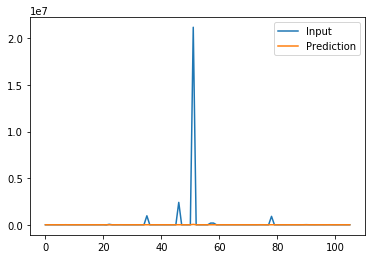

In [95]:
#reshape the test_predictions and compare input vs output from the autoencoder
single_point = test_predictions[9]
single_point = np.reshape(single_point, (1, single_point.shape[0]))
single_point = scaler.inverse_transform(single_point)

single_point_input = X_test[9]
single_point_input = np.reshape(single_point_input, (1, single_point_input.shape[0]))
single_point_input = scaler.inverse_transform(single_point_input)

#plot the predicted values against the actual values
plt.plot(single_point_input.flatten(), label='Input')
plt.plot(single_point.flatten(), label='Prediction')
plt.legend()
plt.show()


In [89]:
test_predictions[5]

array([-1.6230707 , -1.8218312 , -0.37605423, -0.7723876 ,  1.3679987 ,
        1.4180673 ,  1.1735877 , -1.810057  ,  1.4677052 ,  1.0981249 ,
        0.70432854, -0.13373765, -1.0359746 , -0.40917838,  0.7639164 ,
       -0.1974544 ,  0.10199107, -0.14384477,  0.26843688,  1.4433725 ,
        2.4299166 , -0.8869995 ,  2.2309036 , -0.25827524, -0.33660677,
        1.7704923 , -0.83719236, -1.4858837 ,  0.09707838, -0.08418947,
        0.04311462, -0.6158545 ,  0.05470623,  0.05646607, -0.0940793 ,
        0.26976895, -1.1109338 , -0.31608596,  1.487269  ,  2.1229942 ,
        0.25955153,  0.18011199,  0.27378035,  0.3404412 ,  0.13598867,
        0.14659688, -1.781765  , -0.03000461, -0.06912411,  1.8068503 ,
        0.14128897,  0.04796102, -0.39658767, -0.5231597 , -0.48113507,
       -0.4805438 , -0.5315332 , -0.11042593, -0.13045676,  0.19616297,
        1.0601652 , -0.2738784 ,  1.8150625 ,  0.02694033,  1.7576287 ,
        0.7941342 ,  0.69001305,  1.4942552 ,  0.11999851,  0.07

In [90]:





#use a 2dconv model to predict the next value
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D 
from keras.layers import Dropout
from keras.layers import LSTM


from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense


#convert to numpy array
df_np=df.to_numpy()

#train test split
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_np, test_size=0.2, random_state=False)

#normalize the x_train
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#reshape the data for a 1dconv model

model_shape = X_train_scaled.shape
X_train_3d = X_train_scaled.reshape( -1, model_shape[0], model_shape[1])

#resize the data for validation
X_test_scaled = scaler.fit_transform(X_test)
X_test_shape = X_test_scaled.shape
X_test_3d = X_test_scaled.reshape( -1, X_test_shape[0], X_test_shape[1])

#create a cnn model for outlier detection using 1dconv
nn_model = tf.keras.models.Sequential()

#add a 1dconv layer
nn_model.add(tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(model_shape[0], model_shape[1])))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(32, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(8, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(4, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(2, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))
nn_model.add(tf.keras.layers.Conv1D(1, 2, activation='relu'))
nn_model.add(tf.keras.layers.MaxPooling1D(2))






nn_model.add(tf.keras.layers.Flatten())

#add a dense layer

nn_model.add(tf.keras.layers.Dense(100, activation='relu'))
nn_model.add(tf.keras.layers.Dense(10, activation='relu'))
nn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#pad the X_test_3d to match the model shape
X_test_3d = np.pad(X_test_3d, ((0,0),(0, model_shape[0]-X_test_shape[0]), (0,0)), 'constant')

#compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#fit the model to prevent incompatiblity errors
nn_model.fit(X_train_3d, X_train_3d, epochs=5)





#predict the model
nn_model.predict(X_test_3d)












nn_model.summary()

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 1.0618 - accuracy: 0.1415
Epoch 2/5
1/1 [==============================] - 0s 249ms/step - loss: 1.0245 - accuracy: 0.1415
Epoch 3/5
1/1 [==============================] - 0s 251ms/step - loss: 0.9246 - accuracy: 0.1415
Epoch 4/5
1/1 [==============================] - 0s 248ms/step - loss: 0.8882 - accuracy: 0.1415
Epoch 5/5
1/1 [==============================] - 0s 254ms/step - loss: 0.8715 - accuracy: 0.1415
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_119 (Conv1D)         (None, 73794, 64)         13632     
                                                                 
 max_pooling1d_119 (MaxPooli  (None, 36897, 64)        0         
 ng1D)                                                           
                                                                 
 conv1d_120 (Conv1D)         (Non

In [91]:
#save the model
nn_model.save('model.h5')

In [92]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "browser"

#load the model
from keras.models import load_model

model = load_model('model.h5')

#predict the next value on the test data with less rows
#reshape the data to get the expected input shape
X_test_scaled = scaler.fit_transform(X_test)
X_test_3d = X_test_scaled.reshape( -1, X_test_scaled.shape[0], X_test_scaled.shape[1])

#predict the next value
y_pred = model.predict(X_test_3d)



ValueError: in user code:

    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1805, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1794, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1787, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1755, in predict_step
        return self(x, training=False)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_33" is incompatible with the layer: expected shape=(None, 73795, 106), found shape=(None, 18449, 106)


In [ ]:
#clean outliers from df and retrain
df_loss= nn_model.predict(df)

#inverse transform df_loss
df_loss_inv = scaler.inverse_transform(df_loss)

inv_scaled_loss=tf.keras.losses.mae(df_loss_inv, df)

#add a column to df with the loss
df['loss']=inv_scaled_loss

#trend the loss
fig = px.line(df, x=df.index, y='loss')
fig.show()






ValueError: in user code:

    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1805, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1794, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1787, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1755, in predict_step
        return self(x, training=False)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 16500, 106), found shape=(None, 106)


In [ ]:
#clean outliers from df and retrain
df_loss= nn_model.predict(df_duplicate)

#inverse transform df_loss
df_loss_inv = scaler.inverse_transform(df_loss)

inv_scaled_loss=tf.keras.losses.mae(df_loss_inv, df_duplicate)

#add a column to df with the loss

df_duplicate['loss']=inv_scaled_loss





#trend the loss
fig = px.line(df_duplicate, x=df_duplicate.index, y='loss')
fig.show()

